In [8]:
# Esse programa serve para fazer o scraping de dados de Virus e criar um ontologia em OWL
# Autor: Deivis Felipe Guerreiro Fagundes
# Data: 21/05/2023

In [9]:
# Faz o import das bibliotecas
# Selenium é uma biblioteca para fazer o scraping de dados
# Pandas é uma biblioteca para manipular os dados
# Time é uma biblioteca para fazer o programa esperar um tempo
# BeautifulSoup é uma biblioteca para fazer o scraping de dados
# OWLReady2 é uma biblioteca para criar ontologias em OWL
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
import pandas as pd
import time
from bs4 import BeautifulSoup
import os
# biblioteca para criar ontologias usando rdflib
from rdflib import Graph, Literal, RDF, URIRef, Namespace


In [10]:
# Captura a pagina html do site
driver_path = './chromedriver.exe'

service = Service(driver_path)

# inicializa o driver do Selenium que esta dentro da pasta
driver = webdriver.Chrome(service=service)

# acessa o site que contem os dados
driver.get('https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?mode=Undef&name=Viruses&lvl=5&srchmode=1&keep=1&unlock')

time.sleep(1)

# Clica no checkbox com o value "host"
driver.find_element('css selector', "input[value='host']").click()

# Clica no checkbox com o value "viral_host"
driver.find_element('css selector', "input[value='viral_host']").click()

# Clica no botão input com o value "Go"
driver.find_element('css selector', "input[value='Go']").click()

# espera 5 segundos para carregar a pagina
time.sleep(5)

# pega o html da pagina
html = driver.page_source

# fecha o driver
driver.close()



In [11]:
# Faz o scraping dos dados
# cria uma strutura de dados onde cada item pode ter um nome, um link e uma lista de filhos, ou ser virus
class Item:
    def __init__(self, name, link, children, isVirus, hosts, viral_hosts):
        self.name = name
        self.link = link
        self.children = children
        self.isVirus = isVirus
        self.hosts = hosts
        self.viral_hosts = viral_hosts

    # retorna uma string com os dados do item
    def __str__(self):
        return f'Item: {self.name}, Link: {self.link}, isVirus: {self.isVirus}'

# cria uma lista de itens
items = []

quantidade = 0

# Pega o primeiro UL dentro da tag form
ul = BeautifulSoup(html, 'html.parser').find('form').find('ul')

def CriaItem(li, parent):
    # atualiza a quantidade de itens
    global quantidade
    quantidade += 1

    # pega o nome do item
    name = li.find('a').text

    # pega o link do item
    link = li.find('a')['href']

    # pega os filhos do item
    children = []

    # verifica se o item é um virus
    isVirus = False

    # verifica se o item é um virus, se o tipo do li for 'square', então é um virus
    if li['type'] == 'square':
        isVirus = True

    # Pega os hosts do item da tag small dentro do li, onde o texto começa com " Host=", exemplo " Host=plants"
    # apenas se tiver
    hosts = []
    if li.find('small', text=lambda t: t and t.startswith(' Host=')) != None:
        hosts = li.find('small', text=lambda t: t and t.startswith(' Host=')).text.replace(' Host=', '').split('|')

    # Pega os viral hosts do item da tag small dentro do li, onde o texto começa com " Viral Host=", exemplo " Viral Host=plants"
    # apenas se tiver
    viral_hosts = []
    if li.find('small', text=lambda t: t and t.startswith(' Viral Host=')) != None:
        viral_hosts = li.find('small', text=lambda t: t and t.startswith(' Viral Host=')).text.replace(' Viral Host=', '').split('|')


    # cria um item com os dados
    item = Item(name, link, children, isVirus, hosts, viral_hosts)

    # verifica se o item tem um pai
    if parent != None:
        # adiciona o item na lista de filhos do pai
        parent.children.append(item)
    else :
        # adiciona o item na lista de itens
        items.append(item)

    # verifica se o item tem filhos
    if li.find('ul') != None:

        # pega o primeiro UL dentro da tag form
        ul = li.find('ul')

        # pega todos os LI dentro do UL, só filhos diretos
        lis = ul.find_all('li', recursive=False)

        # para cada LI dentro do UL
        for li in lis:

            # chama a função novamente
            CriaItem(li, item)

# para cada LI dentro do UL
for li in ul.find_all('li', recursive=False):
    # chama a função para criar o item
    CriaItem(li, None)

C:\Users\guerr\AppData\Local\Temp\ipykernel_14408\3652346479.py:48: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  if li.find('small', text=lambda t: t and t.startswith(' Host=')) != None:
C:\Users\guerr\AppData\Local\Temp\ipykernel_14408\3652346479.py:49: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  hosts = li.find('small', text=lambda t: t and t.startswith(' Host=')).text.replace(' Host=', '').split('|')
C:\Users\guerr\AppData\Local\Temp\ipykernel_14408\3652346479.py:54: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  if li.find('small', text=lambda t: t and t.startswith(' Viral Host=')) != None:
C:\Users\guerr\AppData\Local\Temp\ipykernel_14408\3652346479.py:55: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  viral_hosts = li.find('small', text=lambda t: t and t.star

In [12]:
# Printa os itens como se fosse uma arvore
def PrintaItens(item, level):
    # printa o nome do item
    print(f'{" " * level}{item.name}')

    # verifica se o item tem filhos
    if len(item.children) > 0:
        # para cada filho do item
        for child in item.children:
            # chama a função novamente
            PrintaItens(child, level + 1)

# printa só o primeiro ramo da arvore
PrintaItens(items[0], 0)

Viruses
 Adnaviria
  Zilligvirae
   Taleaviricota
    Tokiviricetes
     Ligamenvirales
     Primavirales
 Alphasatellitidae
  Coconut foliar decay alphasatellite
  Geminialphasatellitinae
   Ageyesisatellite
    Ageratum yellow vein Singapore alphasatellite
   Clecrusatellite
    Ash gourd yellow vein mosaic alphasatellite
    Capsicum India alphasatellite
     Begomovirus-associated alphasatellite sp.
    Cleome leaf crumple alphasatellite
    Croton yellow vein mosaic alphasatellite
    Euphorbia yellow mosaic alphasatellite
     Euphorbia yellow mosaic virus associated DNA 1
    Melon chlorotic mosaic alphasatellite
    Tomato leaf curl Anand alphasatellite
    Tomato leaf curl New Delhi alphasatellite
    Tomato leaf curl Virudhunagar alphasatellite
    Tomato yellow spot alphasatellite
    Tomato yellow spot alphasatellite 2
    Whitefly associated Guatemala alphasatellite 2
    Whitefly associated Puerto Rico alphasatellite 1
   Colecusatellite
    Ageratum enation alphasatellit

12327


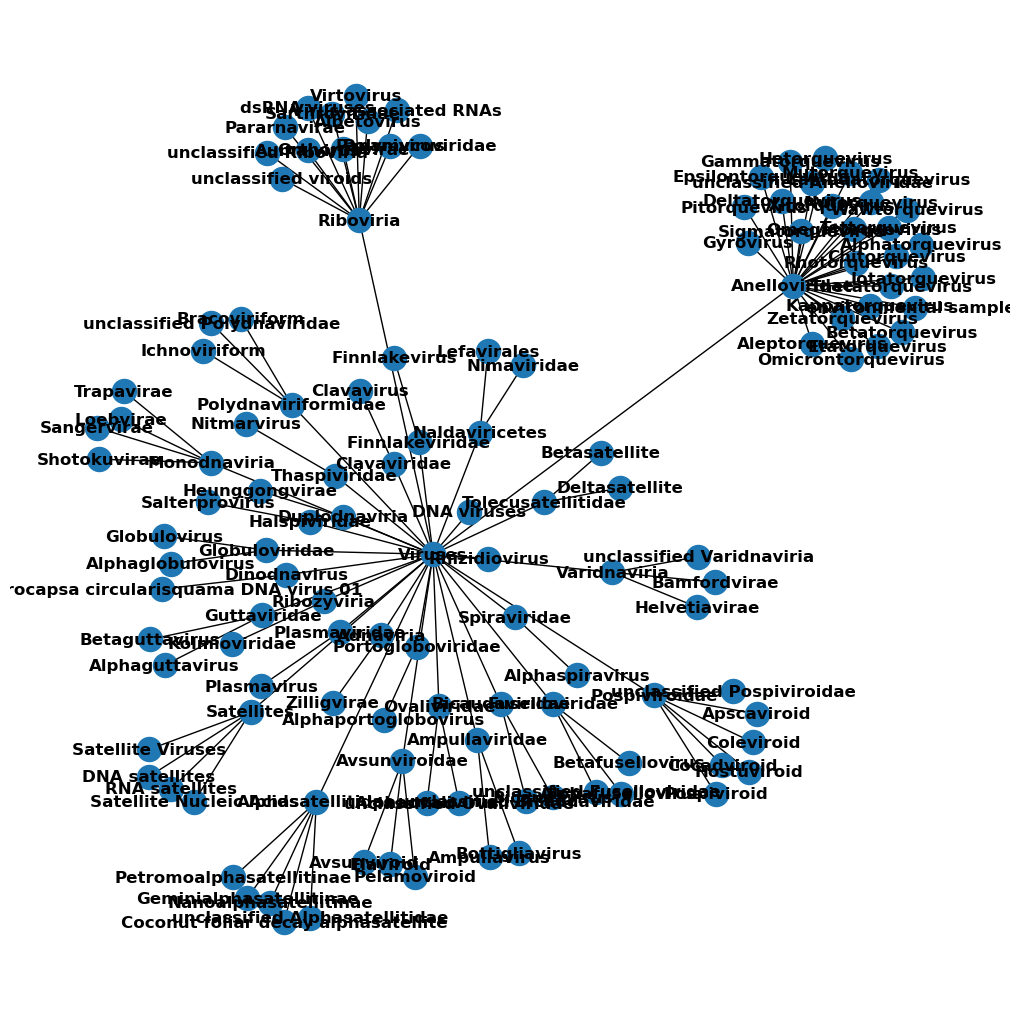

In [13]:
# Printa os itens como se fosse uma arvore usando uma biblioteca grafica
# importa a biblioteca grafica
import networkx as nx
import matplotlib.pyplot as plt

# cria um grafo
G = nx.Graph()

print(quantidade)

# Cria uma função para adicionar itens no grafo recursivamente e recebe um nivel maximo
def AdicionaItens(item, level, maxLevel, quantidadeDeFilhos):
    global G
    # verifica se o nivel é menor que o nivel maximo
    if level < maxLevel:
        # verifica se o item tem filhos
        if len(item.children) > 0:
            filhosIterados = 0
            # para cada filho do item
            for child in item.children:
                # verifica se o filho ja foi iterado
                if filhosIterados >= quantidadeDeFilhos:
                    break

                filhosIterados += 1

                # adiciona o filho no grafo
                G.add_node(child.name)

                # adiciona uma aresta entre o item e o filho
                G.add_edge(item.name, child.name)

                # chama a função novamente
                AdicionaItens(child, level + 1, maxLevel, quantidadeDeFilhos)
            

AdicionaItens(items[0], 0, 2, 30)

# Aumenta o tamanho do grafo
plt.figure(figsize=(10, 10))

# desenha o grafo que aceita muitos itens e niveis
nx.draw(G, with_labels=True, font_weight='bold')

# mostra o grafo
plt.show()

In [14]:
# Insere os dados na ontologia

# Verifica se o arquivo da ontologia existe
if os.path.exists("ontologia.owl"):
    # Remove o arquivo da ontologia
    os.remove("ontologia.owl")

# Cria a ontologia OntologiaVirus usando rdflib
onto = Graph()

# Cria o namespace da ontologia
onto.namespace_manager.bind("OntologiaVirus", URIRef("http://www.semanticweb.org/deivis/ontologies/2023/5/OntologiaVirus#"))

# Cria a classes Host
onto.add((URIRef("http://www.semanticweb.org/deivis/ontologies/2023/5/OntologiaVirus#Host"), RDF.type, URIRef("http://www.w3.org/2002/07/owl#Class")))

def SerializaNome(nome):
    # Serializa o nome e tira caracteres especiais
    return nome.replace(" ", "_").replace("(", "").replace(")", "").replace("/", "").replace("-", "").replace("'", "").replace(".", "").replace(",", "").replace(":", "").replace(";", "").replace("?", "").replace("!", "").replace(">", "").replace("<", "").replace("=", "").replace("+", "").replace("*", "").replace("&", "").replace("%", "").replace("$", "").replace("#", "").replace("@", "")
    
# Percorre os itens recursivamente se não for virus é uma classe, se for é um individuo, usa hierarquia de classes
def PercorreItens(item, parent):
    # Verifica se o item tem hosts, se tiver verifica se a classe já existe, se não existir cria a classe
    if len(item.hosts) > 0:
        for host in item.hosts:
            # Tira os espaços do começo e do fim do nome do host
            nomeHost = host.strip()
            nomeHost = SerializaNome(nomeHost)
            # Verifica se a classe já existe
            if onto.value(subject=None, predicate=URIRef("http://www.w3.org/2000/01/rdf-schema#label"), object=Literal(nomeHost)) == None:
                # Cria a classe
                onto.add((URIRef("http://www.semanticweb.org/deivis/ontologies/2023/5/OntologiaVirus#" + SerializaNome(nomeHost)), 
                        RDF.type, URIRef("http://www.w3.org/2002/07/owl#Class")))
                onto.add((URIRef("http://www.semanticweb.org/deivis/ontologies/2023/5/OntologiaVirus#" + SerializaNome(nomeHost)), 
                        URIRef("http://www.w3.org/2000/01/rdf-schema#label"), Literal(nomeHost)))
                # Cria a relação de subclasse com a classe Host
                onto.add((URIRef("http://www.semanticweb.org/deivis/ontologies/2023/5/OntologiaVirus#" + SerializaNome(nomeHost)),
                            URIRef("http://www.w3.org/2000/01/rdf-schema#subClassOf"), URIRef("http://www.semanticweb.org/deivis/ontologies/2023/5/OntologiaVirus#Host")))

    # Faz a mesma coisa para os viral hosts
    if len(item.viral_hosts) > 0:
        for host in item.viral_hosts:
            # Tira os espaços do começo e do fim do nome do host
            nomeHost = host.strip()
            nomeHost = SerializaNome(nomeHost)
            # Verifica se a classe já existe
            if onto.value(subject=None, predicate=URIRef("http://www.w3.org/2000/01/rdf-schema#label"), object=Literal(nomeHost)) == None:
                # Cria a classe
                onto.add((URIRef("http://www.semanticweb.org/deivis/ontologies/2023/5/OntologiaVirus#" + SerializaNome(nomeHost)), 
                        RDF.type, URIRef("http://www.w3.org/2002/07/owl#Class")))
                onto.add((URIRef("http://www.semanticweb.org/deivis/ontologies/2023/5/OntologiaVirus#" + SerializaNome(nomeHost)),
                        URIRef("http://www.w3.org/2000/01/rdf-schema#label"), Literal(nomeHost)))
                # Cria a relação de subclasse com a classe Host
                onto.add((URIRef("http://www.semanticweb.org/deivis/ontologies/2023/5/OntologiaVirus#" + SerializaNome(nomeHost)),
                        URIRef("http://www.w3.org/2000/01/rdf-schema#subClassOf"), URIRef("http://www.semanticweb.org/deivis/ontologies/2023/5/OntologiaVirus#Host")))

    # verifica se o item é um virus
    if item.isVirus:
        # cria um individuo do item
        individuo = URIRef("http://www.semanticweb.org/deivis/ontologies/2023/5/OntologiaVirus#" + SerializaNome(item.name))
        # adiciona as propriedades do individuo
        onto.add((individuo, URIRef("http://www.w3.org/2000/01/rdf-schema#label"), Literal(item.name)))
        onto.add((individuo, URIRef("http://www.w3.org/2000/01/rdf-schema#comment"), Literal(item.link)))

        # verifica se o item tem um pai
        if parent != "":
            # adiciona o individuo como instancia do pai
            onto.add((individuo, URIRef("http://www.w3.org/1999/02/22-rdf-syntax-ns#type"), parent))

    else:
        # cria uma Entidade classe do item
        classe = URIRef("http://www.semanticweb.org/deivis/ontologies/2023/5/OntologiaVirus#" + SerializaNome(item.name))
        # adiciona a classe na ontologia
        onto.add((classe, RDF.type, URIRef("http://www.w3.org/2002/07/owl#Class")))
        # verifica se o item tem um pai
        if parent != "":
            # adiciona a classe como subclasse do pai
            onto.add((classe, URIRef("http://www.w3.org/2000/01/rdf-schema#subClassOf"), parent))

        # adiciona as propriedades do item
        onto.add((classe, URIRef("http://www.w3.org/2000/01/rdf-schema#label"), Literal(item.name)))
        onto.add((classe, URIRef("http://www.w3.org/2000/01/rdf-schema#comment"), Literal(item.link)))

        # verifica se o item tem filhos
        if len(item.children) > 0:
            # para cada filho do item
            for child in item.children:
                # chama a função novamente
                PercorreItens(child, classe)

# para cada item
for item in items:
    # chama a função para percorrer os itens, pai sendo Thing
    PercorreItens(item, URIRef("http://www.w3.org/2002/07/owl#Thing"))

# salva a ontologia, cria o arquivo
onto.serialize("ontologia.owl", format="xml")

<Graph identifier=Nf96ce563a4b546599fc26b0c89b0948a (<class 'rdflib.graph.Graph'>)>